In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torchsummary import summary

In [4]:
trainset = torch.load('./dataset/train.pt')
valset = torch.load('./dataset/val.pt')

datasets = {'train': trainset, 'val': valset}

batch_size=10

dataloaders = {
    'train': DataLoader(datasets['train'], batch_size=batch_size, shuffle=True, num_workers=8),
    'val': DataLoader(datasets['val'], batch_size=batch_size, shuffle=True, num_workers=8)
}

dataset_sizes = {
    x: len(datasets[x]) for x in datasets.keys()
}

dataset_sizes

{'train': 1159, 'val': 290}

torch.Size([10, 1, 480, 640]) torch.Size([10, 3, 480, 640])
0.0 10.0 1.9948914 1.9609758
0.0 1.0 0.095906466 0.2944638


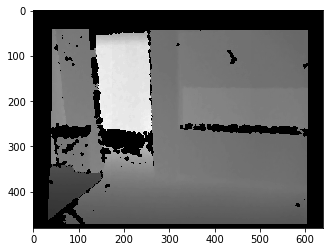

In [3]:
inputs, masks = next(iter(dataloaders['train']))
inputs = inputs.unsqueeze(1)
print(inputs.size(), masks.size())
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

plt.imshow(inputs[3][0], cmap=plt.cm.gist_gray)

In [4]:
# import Unet_bin

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

# model = Unet_bin.UNet(3)
# model = model.to(device)

# summary(model, input_size=(1, 480, 640))

In [5]:
from collections import defaultdict
import torch.nn.functional as F
from loss import dice_loss
import Unet_bin

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.unsqueeze(1)
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                
                torch.save(best_model_wts, './dataset/best_model_wts')

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 3

model = Unet_bin.UNet(num_class).to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=40)

cuda:0
Epoch 0/39
----------
LR 0.0001


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train: bce: 0.358332, dice: 0.882177, loss: 0.620254
val: bce: 0.297418, dice: 0.878856, loss: 0.588137
saving best model
1m 52s
Epoch 1/39
----------
LR 0.0001
train: bce: 0.298179, dice: 0.864964, loss: 0.581572
val: bce: 0.294202, dice: 0.843230, loss: 0.568716
saving best model
1m 53s
Epoch 2/39
----------
LR 0.0001
train: bce: 0.286240, dice: 0.813894, loss: 0.550067
val: bce: 0.269947, dice: 0.796702, loss: 0.533324
saving best model
1m 54s
Epoch 3/39
----------
LR 0.0001
train: bce: 0.267188, dice: 0.755118, loss: 0.511153
val: bce: 0.260867, dice: 0.713336, loss: 0.487102
saving best model
1m 54s
Epoch 4/39
----------
LR 0.0001
train: bce: 0.235934, dice: 0.691145, loss: 0.463539
val: bce: 0.223842, dice: 0.674309, loss: 0.449075
saving best model
1m 54s
Epoch 5/39
----------
LR 0.0001
train: bce: 0.220641, dice: 0.665273, loss: 0.442957
val: bce: 0.209837, dice: 0.651432, loss: 0.430634
saving best model
1m 54s
Epoch 6/39
----------
LR 0.0001
train: bce: 0.210113, dice: 0.6491

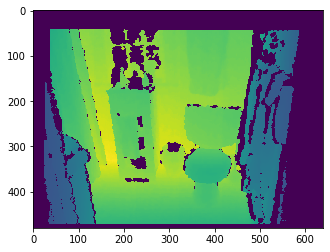

In [9]:
import Unet_bin
num_class=3

dimg_bat = next(iter(dataloaders['val']))
#dimg = np.array(dimg)
dimg = dimg_bat[0][0]
plt.imshow(dimg)

model_predict = Unet_bin.UNet(num_class)
model_predict.load_state_dict(torch.load('./dataset/best_model_wts'))
model_predict.eval()

out = model_predict(dimg.unsqueeze(0).unsqueeze(0))

torch.Size([3, 480, 640])
[[ -8.195042 -12.163204 -13.90271  ... -13.102942 -10.987668  -5.591748]
 [-12.557687 -19.482027 -22.564068 ... -21.680809 -18.500563 -10.743827]
 [-14.643464 -22.971428 -26.735783 ... -26.053186 -22.741377 -13.56895 ]
 ...
 [-11.767622 -18.47599  -20.942747 ... -19.882643 -18.18208  -11.238093]
 [ -9.831228 -16.05601  -18.427517 ... -17.79341  -16.082045 -10.029791]
 [ -6.083049 -10.566404 -12.557858 ... -12.417985 -11.141103  -7.267881]]


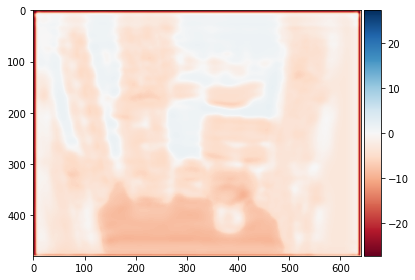

[[ -9.89389  -16.930199 -19.830004 ... -18.82361  -15.522039  -9.260321]
 [-18.09072  -31.597593 -37.488377 ... -36.081562 -30.1739   -18.035295]
 [-22.365753 -39.19703  -46.447784 ... -45.249195 -38.125694 -22.904911]
 ...
 [-18.71493  -32.348885 -37.54319  ... -34.88869  -30.553509 -18.824715]
 [-16.204256 -28.381855 -33.356415 ... -31.55437  -27.319088 -16.768097]
 [-11.099208 -19.660831 -23.343967 ... -22.4305   -19.451244 -11.937075]]


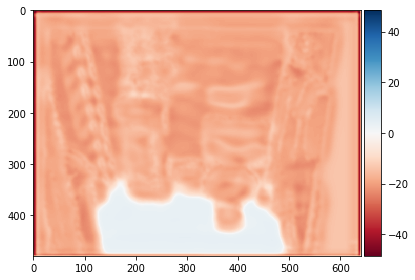

[[-16.476456 -27.09832  -32.532635 ... -31.577646 -26.97672  -15.695649]
 [-26.752174 -44.67752  -53.73517  ... -52.474613 -45.23519  -27.096443]
 [-31.196043 -51.898525 -61.827133 ... -60.724277 -52.708202 -31.879194]
 ...
 [-25.567549 -41.961563 -49.085064 ... -47.270477 -41.595642 -25.495443]
 [-21.546547 -35.37104  -41.66631  ... -40.778908 -35.40811  -21.893896]
 [-14.040623 -23.298784 -27.560932 ... -27.134352 -23.33438  -14.792006]]


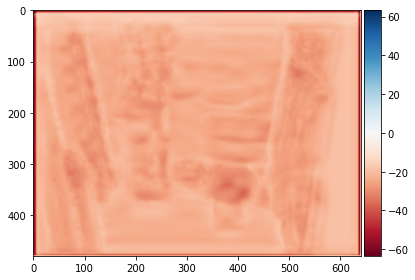

In [14]:
from skimage import io

msk_prd = out[0]
print(msk_prd.size())
for msk_p in msk_prd:
    msk_p = np.array(msk_p.detach())
    print(msk_p)
    io.imshow(msk_p)
    io.show()